In [ ]:
from UCI_Dataset.MakeDataset import X_train, y_train
import matplotlib.pyplot as plt
import numpy as np

class_names = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

plt.figure(figsize=(18, 3))

for i, (class_label, class_name) in enumerate(class_names.items(), 1):

    idx = np.where(y_train == class_label)[0][0]
    sample = X_train[idx]  
    
    time_axis = np.arange(sample.shape[0]) / 50.0  
    
    plt.subplot(1, 6, i)
    plt.plot(time_axis, sample[:, 0], label="acc_x")
    plt.plot(time_axis, sample[:, 1], label="acc_y")
    plt.plot(time_axis, sample[:, 2], label="acc_z")
    
    plt.title(class_name)
    plt.legend()

plt.plot()
plt.savefig(f"q1.png")
plt.close()

# the model will be able to classify the activities based on the accelerometer data 
# as the patterns in the data are distinct for each activity.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

plt.figure(figsize=(18, 3))

for i, (class_label, class_name) in enumerate(class_names.items(), 1):
    idx = np.where(y_train == class_label)[0][0]   
    sample = X_train[idx]

    acc_total = np.sqrt(sample[:,0]**2 + sample[:,1]**2 + sample[:,2]**2)
    time_axis = np.arange(sample.shape[0]) / 50.0   

    plt.subplot(1, 6, i)
    plt.plot(time_axis, acc_total)
    plt.title(class_name)
    plt.ylim(0, 3)

plt.plot()
plt.savefig("q2.png")
plt.close()



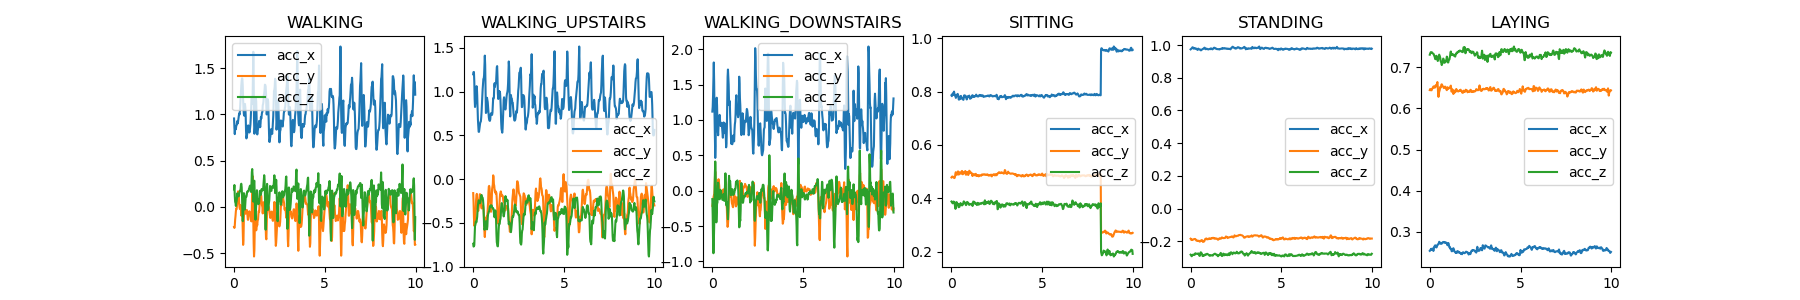

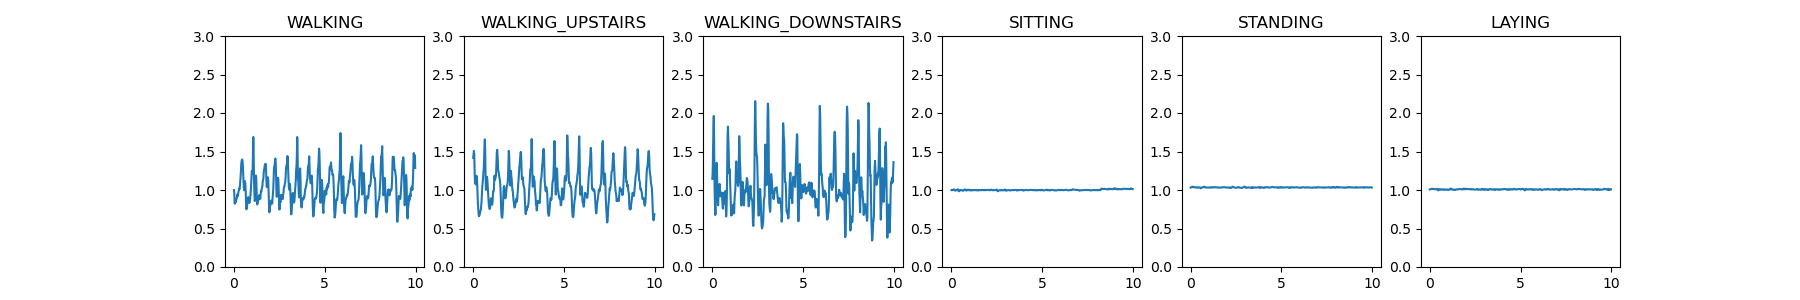

In [12]:
from IPython.display import Image, display
display(Image(filename="q1.png"))
display(Image(filename="q2.png"))

The difference in total acceleration between static and dynamic activities is quite clear, 
as static activities have low, nearly constant acceleration while dynamic activities show 
higher magnitudes with wavy patterns, making a simple thresholding rule sufficient to 
distinguish between the two groups; however, within-group classification, such as differentiating 
sitting from standing or distinguishing walking from walking upstairs, requires a machine 
learning model since the variations are more subtle and not easily captured by simple rules.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tsfel  
import pandas as pd

class_names = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

# 1. PCA on Total Acceleration

total_acc = np.sqrt(np.sum(X_train**2, axis=2))  

pca_total = PCA(n_components=2)
X_total_pca = pca_total.fit_transform(total_acc)

for class_label in class_names:
    idx = np.where(y_train == class_label)[0]
    plt.scatter(X_total_pca[idx,0], X_total_pca[idx,1], label=class_names[class_label])
plt.title("PCA on Total Acceleration")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.savefig("q3_total_acceleration_pca.png")
plt.close()

# ------------------------------------------------------------------------------------
# 2. PCA on TSFEL Features

cfg = tsfel.get_features_by_domain()  

useful_cfg = {
    "statistical": {
        "Mean": cfg["statistical"]["Mean"],
        "Standard deviation": cfg["statistical"]["Standard deviation"]
    },
    "temporal": {
        "Neighbourhood peaks": cfg["temporal"]["Neighbourhood peaks"]
    },
    "spectral": {
        "Spectral centroid": cfg["spectral"]["Spectral centroid"],
        "Maximum frequency": cfg["spectral"]["Maximum frequency"]
    }
}

X_tsfel = []
axis_labels = ['x', 'y', 'z']

for sample in X_train:
    df_sample = pd.DataFrame(sample, columns=["x","y","z"])
    features = tsfel.time_series_features_extractor(useful_cfg, df_sample)
    X_tsfel.append(features.values.flatten())

X_tsfel = np.array(X_tsfel)

pca_tsfel = PCA(n_components=2)
X_tsfel_pca = pca_tsfel.fit_transform(X_tsfel)

for class_label, class_name in class_names.items():
    idx = np.where(y_train == class_label)[0]
    plt.scatter(X_tsfel_pca[idx,0], X_tsfel_pca[idx,1], label=class_name)

plt.title("PCA on TSFEL Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.savefig("q3_tsfel_features_pca.png")
plt.close()

# ------------------------------------------------------------------------------------
# 3. PCA on Dataset-Provided Features

# Compute simple statistical features from the dataset 

X_dataset = np.loadtxt('UCI_Dataset/train/X_train.txt')

# print("X shape:", X.shape)  # (7352, 561)

pca_dataset = PCA(n_components=2)
X_dataset_pca = pca_dataset.fit_transform(X_dataset)

plt.figure(figsize=(6,5))
for class_label in class_names:
    idx = np.where(y_train == class_label)[0]
    plt.scatter(X_dataset_pca[idx,0], X_dataset_pca[idx,1], label=class_names[class_label])
plt.title("PCA on Dataset Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.savefig("q3_dataset_features_pca.png")
plt.close()

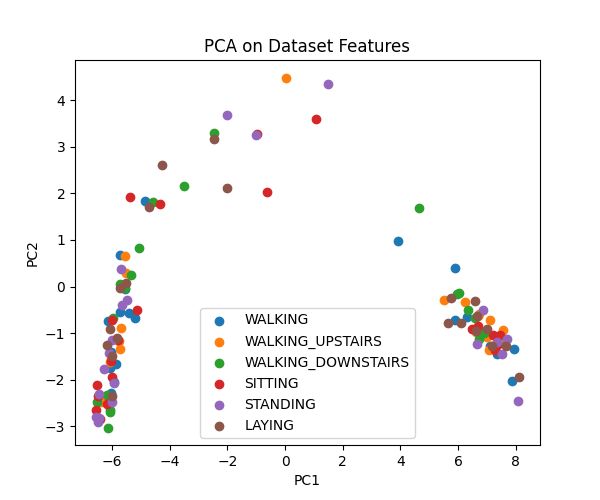

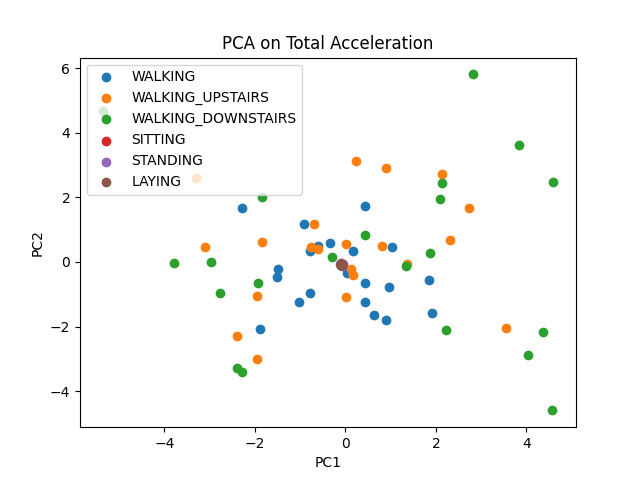

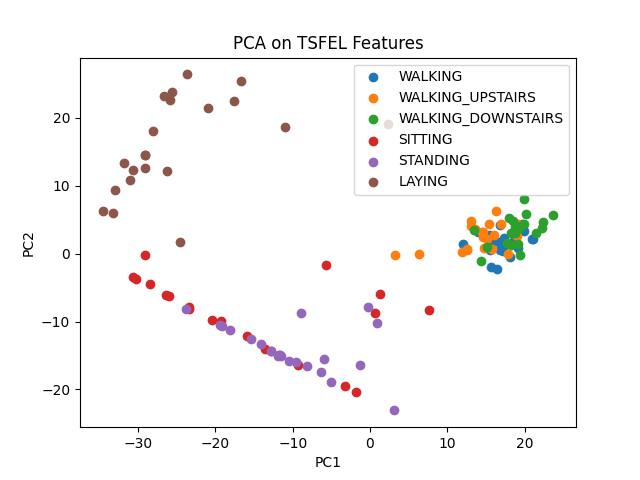

In [13]:
display(Image(filename="q3_dataset_features_pca.png"))
display(Image(filename="q3_total_acceleration_pca.png"))
display(Image(filename="q3_tsfel_features_pca.png"))

We compared PCA-based visualizations using three types of features: total acceleration, TSFEL features, and the 
dataset-provided features. PCA on total acceleration showed significant overlap between classes, as collapsing 
the three axes into a single magnitude loses directional information. PCA on total acceleration shows weak separation. 
TSFEL features can often outperform the 561 precomputed features in the UCI HAR .txt files for decision tree models 
because they are more customizable and discriminative. While the UCI HAR features are fixed and high-dimensional, 
designed for general classifiers like SVMs, they may include irrelevant or noisy features that reduce a tree’s 
effectiveness. The selected TSFEL features are more informative and better suited for this task.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dataset features
df_dataset = pd.DataFrame(X_dataset)
df_dataset.columns = [f"D_{i}" for i in range(df_dataset.shape[1])]  # Example: D_0, D_1, ...

# TSFEL features
tsfel_feat_names = []
axes = ["x", "y", "z"]
feat_names = ["Mean", "Std", "Peaks", "Centroid", "MaxFreq"]  
for f in feat_names:
    for ax in axes:
        tsfel_feat_names.append(f"{f}_{ax}")

df_tsfel = pd.DataFrame(X_tsfel, columns=tsfel_feat_names)

df_all = pd.concat([df_dataset, df_tsfel], axis=1)

corr_all = df_all.corr()

plt.imshow(corr_all, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title("Correlation Heatmap of All Features")

plt.savefig("q4.png")
plt.close()

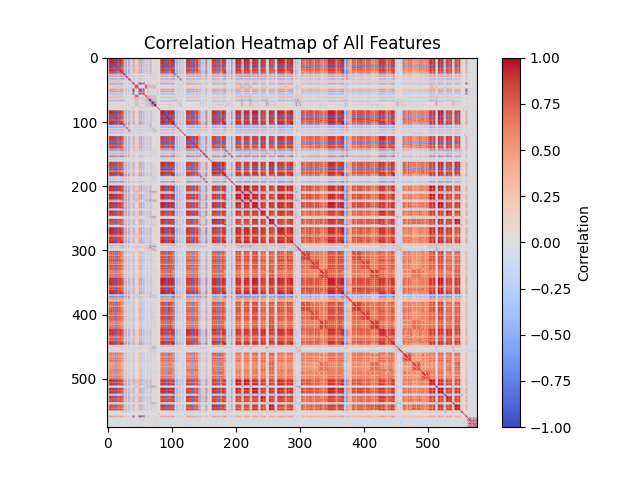

In [14]:
display(Image(filename="q4.png"))